Plot the correlation between tags and transcriptome signal.

Input: splotch lambdas files STB59

Annotation file is the covariets file from splotch

In [1]:
from __future__ import absolute_import, division, print_function

import os
import re
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn import preprocessing
from scipy.stats import linregress, spearmanr, pearsonr
import numpy as np
import math

import seaborn as sns

from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

%matplotlib inline

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial',
                           'ps.fonttype':42})

In [2]:
path = '../../smomics_data'


# mRNA

In [3]:
# Load Lambda pmean df

# Read file
filename = os.path.join(path, 'lambdas_pmeans_gene.tsv')
    
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1])

FileNotFoundError: [Errno 2] No such file or directory: '../../smomics_data/lambdas_pmeans_gene.tsv'

In [5]:
# Change names on genes, ie remove '_'
nwe=[]
nm=lambda_posterior_means.index
for item in nm:
    nwe.append(str(item).split("_")[0])
lambda_posterior_means.index = nwe

# Take exp()
lambda_posterior_means = lambda_posterior_means.astype(float)
lambda_posterior_means = np.exp(lambda_posterior_means-1)


In [6]:
# Select Ighd gene
pd.set_option('display.max_colwidth', -1)
gene = 'Adgre1'

lambda_gene = lambda_posterior_means.loc[gene, :].to_frame().reset_index()

# Get name of file, for plotting
lambda_gene['name'] = lambda_gene['file'].str.split('/').str[-1].str.split('_stdata').str[0]

print(lambda_gene.head(), lambda_gene.shape)


                                                                                                                                              file  \
0  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/STB59_spleen/exons/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   
1  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/STB59_spleen/exons/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   
2  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/STB59_spleen/exons/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   
3  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/STB59_spleen/exons/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   
4  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/STB59_spleen/exons/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   

  coordinate        Adgre1          name  
0  30_24      5.955317e-27  10015CN87_D1  
1  23_20     

# Ab

In [7]:
# Load Lambda pmean df

# Read file
filename = os.path.join(path, 'lambdas_pmeans_tags.tsv')
    
lambda_posterior_meansTAGS = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1])

# Take exp()
lambda_posterior_meansTAGS = lambda_posterior_meansTAGS.astype(float)
lambda_posterior_meansTAGS = np.exp(lambda_posterior_meansTAGS-1)


In [8]:
ab = 'F480-TTAACTTCAGCCCGT'

lambda_tag = lambda_posterior_meansTAGS.loc[ab, :].to_frame().reset_index()

# Get name of file, for plotting
lambda_tag['name'] = lambda_tag['file'].str.split('/').str[-1].str.split('_stdata').str[0]

print(lambda_tag.head(), lambda_tag.shape)

                                                                                                                                             file  \
0  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_stn59/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   
1  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_stn59/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   
2  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_stn59/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   
3  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_stn59/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   
4  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_stn59/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   

  coordinate  F480-TTAACTTCAGCCCGT          name  
0  30_24      55.072993             10015CN87_D1  
1  

# Annotation

In [9]:
annot_list = []

for stdata in list(set(lambda_tag['name'].tolist())):
    
    well = stdata
    
    filename = os.path.join(path, well + '_stdata_adjusted.tsv.annotations.tsv')

    annot_file = pd.read_csv(filename, sep = '\t')
    annot_file = pd.melt(annot_file, id_vars='Unnamed: 0')
    annot_file = annot_file[annot_file['value'] != 0]
    annot_file['image'] = well
    annot_file.drop(['value'], axis=1, inplace=True)
    annot_file.rename(columns = {'Unnamed: 0':'value', 'variable':'x_y'}, inplace=True)

    annot_list.append(annot_file)
    
# Concat
annotdf = pd.concat(annot_list)

print(annotdf.head())

         value    x_y         image
0   B follicle  18_3   10015CN87_C1
8   Red pulp    23_9   10015CN87_C1
13  Red pulp    18_33  10015CN87_C1
18  Red pulp    15_13  10015CN87_C1
23  Red pulp    13_8   10015CN87_C1


In [10]:
print(list(set(annotdf['image'].tolist())))


# How many spots of each region?
print(annotdf.groupby(['image', 'value']).count())

['10015CN87_C1', '10015CN87_D1', '10015CN87_D2', '10015CN87_E2']
                            x_y
image        value             
10015CN87_C1 B follicle     170
             Marginal zone  54 
             PALS           66 
             Red pulp       282
             White pulp     3  
10015CN87_D1 B follicle     140
             Marginal zone  31 
             PALS           40 
             Red pulp       213
10015CN87_D2 B follicle     140
             Marginal zone  34 
             PALS           54 
             Red pulp       237
10015CN87_E2 B follicle     102
             Marginal zone  32 
             PALS           33 
             Red pulp       174


# Merge gene + ab + annotation

In [11]:
lambdadfTMP = pd.merge(lambda_gene, lambda_tag,  how='left', on=['name','coordinate'])
lambdadf = pd.merge(lambdadfTMP, annotdf, how='left', left_on=['name','coordinate'], right_on=['image', 'x_y'])

print(lambdadf.head())


                                                                                                                                            file_x  \
0  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/STB59_spleen/exons/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   
1  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/STB59_spleen/exons/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   
2  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/STB59_spleen/exons/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   
3  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/STB59_spleen/exons/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   
4  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/STB59_spleen/exons/output/Count_Tables/10015CN87_D1_stdata_adjusted.tsv   

  coordinate        Adgre1          name  \
0  30_24      5.955317e-27  10015CN87_D1   
1  23_20   

In [12]:
# Only lok at specific regions
lambdadf_rm = lambdadf[lambdadf['value'].isin(['Red pulp', 'B follicle', 'PALS', 'Marginal zone'])]
#lambdadf_rm = lambdadf.copy()

In [13]:
# Remove sample (only want 3 samples)

sample_to_rm = ['10015CN87_E2']

lambdadf_rm = lambdadf_rm[lambdadf_rm['name'] != sample_to_rm[0]]

print(list(set(lambdadf_rm['name'].tolist())))

['10015CN87_C1', '10015CN87_D1', '10015CN87_D2']


In [14]:
# Take mean per region per sample

trans = lambdadf_rm.groupby(['name', 'value'])[ab, gene].mean()

trans.reset_index(inplace=True)

# Scale min max per sample
trans[[ab + '.norm', gene + '.norm']] = trans.groupby(['name'])[ab, gene].transform(lambda x: preprocessing.minmax_scale(x))

print(trans.head())

           name          value  F480-TTAACTTCAGCCCGT        Adgre1  \
0  10015CN87_C1  B follicle     57.728315             1.318819e-03   
1  10015CN87_C1  Marginal zone  60.038330             5.878256e-03   
2  10015CN87_C1  PALS           58.220771             5.884618e-27   
3  10015CN87_C1  Red pulp       64.489046             2.236631e-03   
4  10015CN87_D1  B follicle     57.605021             1.312925e-03   

   F480-TTAACTTCAGCCCGT.norm  Adgre1.norm  
0  0.000000                   0.224355     
1  0.341681                   1.000000     
2  0.072841                   0.000000     
3  1.000000                   0.380492     
4  0.039467                   0.223981     


std err:0.33
Spearman's rho: 0.63 pvalue: 0.028
Pearson's r: 0.232


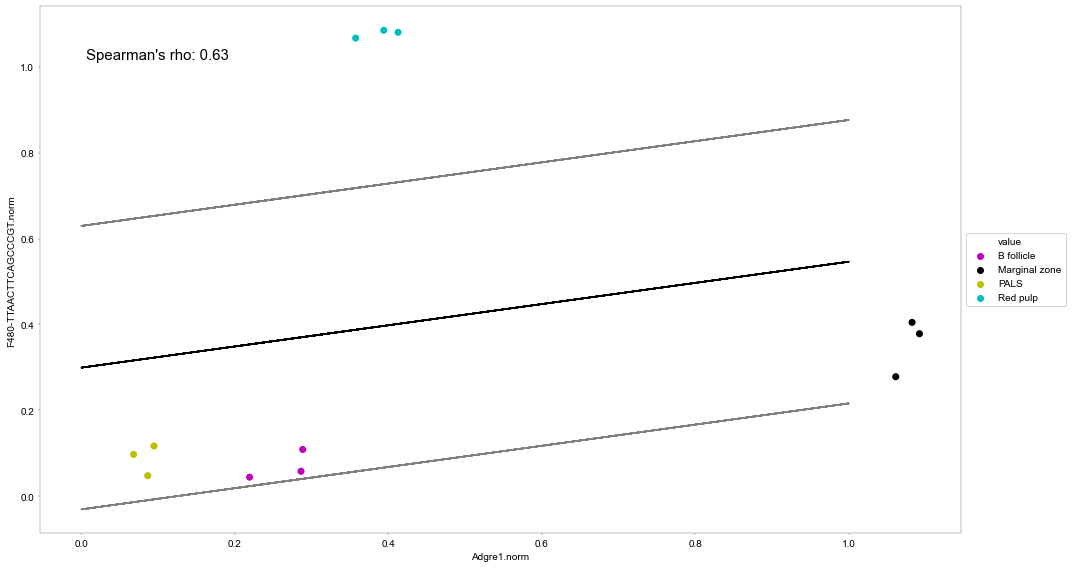

In [15]:
# Plot

# initialize a figure
fig, ax = plt.subplots(figsize=(15, 8))

plot_trans = trans.copy()

plot_trans['jitter_y'] = trans[ab + '.norm'] + 0.1 * np.random.rand(len(trans[ab + '.norm'].tolist())) +0.01
plot_trans['jitter_x'] = trans[gene + '.norm'] + 0.1 * np.random.rand(len(trans[gene + '.norm'].tolist())) +0.01
x = 'jitter_x'
y = 'jitter_y'
hue = 'value'
palette = {'Red pulp':'c', 'B follicle':'m', 'PALS':'y', 'Marginal zone':'k'}
data = plot_trans

sns.scatterplot(x=x, y=y, data=data, ax=ax, hue=hue, s=50, linewidth=0, palette=palette)

# X and Y axis
ax.set_xlabel(gene + '.norm')
ax.set_ylabel(ab + '.norm')

# Calculate the linear regression
X = gene + '.norm'
Y = ab + '.norm'

slope, intercept, r_value, p_value, std_err = linregress(data[X], data[Y])

print('std err:' + str(round(std_err, 3)))

coef = np.polyfit(data[X],data[y],1)
poly1d_fn = np.poly1d(coef)
ax.plot(data[X], poly1d_fn(data[X]), c="k")
ax.plot(data[X], poly1d_fn(data[X])+std_err, c="grey")
ax.plot(data[X], poly1d_fn(data[X])-std_err, c="grey")
#ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

# Spearman's & Pearson's r
spear, ps = spearmanr(data[X], data[Y])
pear, pp = pearsonr(data[X], data[Y])
print("Spearman's rho: " + str(round(spear, 3)) + ' pvalue: ' + str(round(ps, 3)))
print("Pearson's r: " + str(round(pear, 3)))

ax.text(0.05, 0.9, "Spearman's rho: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=15)

#ax.get_legend().remove()

# title
#ax.set_title(region)

#ax.set_xlim([0, 1])
#ax.set_ylim([0, 1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

#plt.savefig("/Users/brittalotstedt/Documents/Documents-dhcp-18-40-114-33/data/stdata/manuscript/ST2.5/mRNAvsTAG_F480.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200, rasterized=True)